Data Preparation

In [ ]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bz2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
#Used to solve issue with .draw not working with collab
!pip install --upgrade scikit-image

     |████████████████████████████████| 29.2MB 177kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [ ]:
# coords_to_image(y_data_raw, shape=(*x_data.shape[:3], 1))
def coords_to_image_full(coords, shape=(500,500,1), high_value=0.999):
    '''
    convert a list of tuples of jar coordinates into an image with entire circles filled.
    TODO the high value must be lower than 1 for Keras.
    '''

    from skimage.draw import disk

    image = np.zeros(shape, dtype='float32')
    for i, pt_list in enumerate(coords): # TODO rewrite with better looping
        for pt in pt_list:
          borderIntensity = 0.333
          for x in [35,30,25,20,15,10]:
            rr, cc = disk(pt, x) # draw a circle of radius x
            image[i, cc, rr, :] = borderIntensity # write it onto the image
            borderIntensity += 0.111
            

    return image

In [ ]:
''' load the data from the archive files '''

from glob import glob
import bz2
import pickle

dataset = list()

# loads every archive of the dataset
archive_list = glob('*.pkl.bz2')
for archive in archive_list:
    with bz2.BZ2File(archive, mode='r') as f:
        dataset.extend(pickle.load(f))

print('archives contained', len(dataset), 'datapoints')

archives contained 340 datapoints


In [ ]:
''' load the data and make usable the data '''

x_data = np.asarray([a['image']/255.0 for a in dataset if not a['testing']], dtype=np.float32)

y_data_raw = [a['label'] for a in dataset if not a['testing']]
y_data_image = coords_to_image_full(y_data_raw, shape=(*x_data.shape[:3], 1))

# Clear Unused Dataset
dataset = None

print('loaded', len(x_data), 'datapoints from file')

loaded 340 datapoints from file


In [ ]:
''' augment the data with flips and rotations '''

x_data_aug = list()
y_data_aug = list()
for image, label in zip(x_data, y_data_image):
    x_data_aug.extend([np.rot90(image, i) for i in range(4)])
    y_data_aug.extend([np.rot90(label, i) for i in range(4)])
    x_data_aug.extend([np.flip(image, i) for i in (0, 1, (0,1), (1,0))])
    y_data_aug.extend([np.flip(label, i) for i in (0, 1, (0,1), (1,0))])

# clear unused large things
x_data = None
y_data_image = None

# add an axis so it works in Keras
x_data_aug = [np.reshape(image, (1, *image.shape)) for image in x_data_aug]
y_data_aug = [np.reshape(image, (1, *image.shape)) for image in y_data_aug]

print('transfoamtions comeplete. resulted in', len(y_data_aug), 'datapoints')

transfoamtions comeplete. resulted in 2720 datapoints


In [ ]:
''' convert to tensor flow dataset '''

master_dataset = tf.data.Dataset.from_tensor_slices((
    np.asarray(x_data_aug, dtype=np.float32), 
    np.asarray(y_data_aug, dtype=np.float16)
))

# clear unused big things
x_data_aug = None
y_data_aug = None

# shuffle it up
master_dataset = master_dataset.shuffle(23)

print('created dataset')

created dataset


Text(0.5, 1.0, 'labeled values')

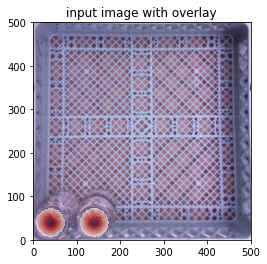

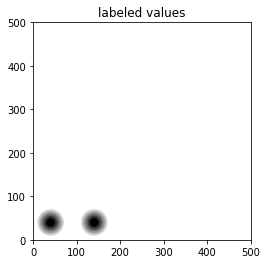

In [ ]:
''' visualize a sample. the red on the image is where the opening is. '''

rand_image = iter(master_dataset.take(1)).get_next()

overlay = np.squeeze(np.asarray(rand_image[1], dtype=np.float32), axis=0)
overlay[overlay < 0.1] = None

fig, ax = plt.subplots()
plt.imshow(np.squeeze(rand_image[0], axis=0))
plt.imshow(np.squeeze(overlay), cmap='Reds', alpha=0.6)
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('input image with overlay')

fig, ax = plt.subplots()
plt.imshow(np.squeeze(overlay), cmap='binary')
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('labeled values')

In [ ]:
''' split the dataset into training and testing '''
training_proportion = 0.85

training_size = int(np.floor(len(master_dataset) * training_proportion))
testing_size = len(master_dataset) - training_size

print('total data points:\t', len(master_dataset))
print('training data points:\t', training_size)
print('testing data points:\t', testing_size)



total data points:	 2720
training data points:	 2312
testing data points:	 408


In [89]:
l2 = None
dense_scale = 5
crop_amount = 10
input_size = list(master_dataset.take(1)._flat_shapes[0])[1:] # checks the shape of the 1st input data and manipulates it to make Keras happy

assert(input_size[0] % dense_scale == 0)

dense_shape = input_size[0]/dense_scale
dense_units = dense_shape * dense_shape

model = keras.Sequential([
    keras.layers.Input(
        shape=input_size, 
        dtype=np.float32
    ),
    keras.layers.Conv2D(
        filters=16,
        kernel_size=7,
        padding='same',
        activation='relu',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l2
    ),
    keras.layers.BatchNormalization(
        momentum=0.99
    ),
    keras.layers.Conv2D(
        filters=32,
        kernel_size=7,
        padding='same',
        activation='relu',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l2
    ),
    keras.layers.BatchNormalization(
        momentum=0.99
    ),
    keras.layers.AveragePooling2D(
        pool_size = 7, 
        strides = 1, 
        padding = 'same'
    ),
    keras.layers.Conv2D(
        filters=32,
        kernel_size=7,
        padding='same',
        activation='relu',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l2
    ),
    keras.layers.BatchNormalization(
        momentum=0.99
    ),
    keras.layers.Conv2D(
        filters=1,
        kernel_size=7,
        padding='same',
        activation='relu',
        kernel_initializer='glorot_normal',
        kernel_regularizer=l2
    )
    
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 500, 500, 16)      2368      
_________________________________________________________________
batch_normalization_21 (Batc (None, 500, 500, 16)      64        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 500, 500, 32)      25120     
_________________________________________________________________
batch_normalization_22 (Batc (None, 500, 500, 32)      128       
_________________________________________________________________
average_pooling2d_4 (Average (None, 500, 500, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 500, 500, 32)      50208     
_________________________________________________________________
batch_normalization_23 (Batc (None, 500, 500, 32)     

In [90]:
#Define Loss Function
def loss_function(y_true, y_pred):
    squared_diff = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_diff)

In [91]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=opt,
    loss=loss_function, 
    metrics = 'accuracy'
)

In [92]:
model.fit(
    x = master_dataset.take(training_size), 
    batch_size = 32,
    epochs= 8
)

Epoch 1/8
2312/2312 [==============================] - 159s 68ms/step - loss: 0.0391 - accuracy: 0.8119
Epoch 2/8
2312/2312 [==============================] - 159s 69ms/step - loss: 0.0124 - accuracy: 0.8221
Epoch 3/8
2312/2312 [==============================] - 158s 68ms/step - loss: 0.0093 - accuracy: 0.8224
Epoch 4/8
2312/2312 [==============================] - 158s 68ms/step - loss: 0.0081 - accuracy: 0.8227
Epoch 5/8
2312/2312 [==============================] - 158s 68ms/step - loss: 0.0071 - accuracy: 0.8228
Epoch 6/8
2312/2312 [==============================] - 158s 68ms/step - loss: 0.0065 - accuracy: 0.8227
Epoch 7/8
2312/2312 [==============================] - 158s 68ms/step - loss: 0.0060 - accuracy: 0.8230
Epoch 8/8
2312/2312 [==============================] - 158s 68ms/step - loss: 0.0056 - accuracy: 0.8230


In [93]:
loss, acc = model.evaluate(x=master_dataset.skip(training_size))
print('test accuracy:', acc)
print('test loss:', loss)


408/408 [==============================] - 20s 19ms/step - loss: 0.0240 - accuracy: 0.7974
test accuracy: 0.7973754405975342
test loss: 0.02401985414326191


In [94]:
''' convert and save model in tflite format '''

from datetime import datetime

# format is YYYYMMDDHHmm
filename = 'model_' + datetime.now().strftime('%Y%m%d%H%M') + '.tflite'
print('writing', filename)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(filename, 'wb') as f:
    f.write(tflite_model)

writing model_202104240239.tflite
INFO:tensorflow:Assets written to: /tmp/tmphf96vnxx/assets


INFO:tensorflow:Assets written to: /tmp/tmphf96vnxx/assets


Text(0.5, 1.0, 'Raw Model Ouput')

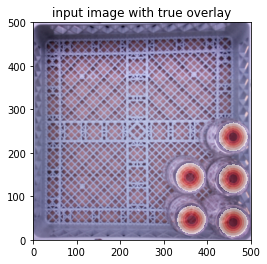

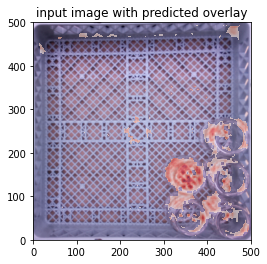

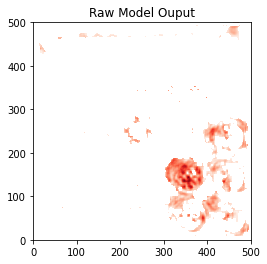

In [97]:
''' test an image and visualise it '''

rand_image = iter(master_dataset.shuffle(200).take(1)).get_next()

pred = model.predict(np.asarray(rand_image[0]))

overlay_true = np.squeeze(np.asarray(rand_image[1], dtype=np.float32), axis=0)
overlay_true[overlay_true < 0.1] = None

overlay_pred = np.squeeze(pred, axis=0)
overlay_pred[overlay_pred < 0.1] = None

fig, ax = plt.subplots()
plt.imshow(np.squeeze(np.squeeze(rand_image[0], axis=0)))
plt.imshow(np.squeeze(overlay_true), cmap='Reds', alpha=0.6)
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('input image with true overlay')

fig, ax = plt.subplots()
plt.imshow(np.squeeze(np.squeeze(rand_image[0], axis=0)))
plt.imshow(np.squeeze(overlay_pred), cmap='Reds', alpha=0.6)
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('input image with predicted overlay')


plt.figure()
plt.imshow(np.squeeze(overlay_pred), cmap='Reds')
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.title('Raw Model Ouput')
